In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
#matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)


# Import preprocessing functions
try:
    from src.data_preprocessing import (
        load_data, clean_text, normalize_spelling, generate_variants,
        balance_dataset, save_processed, preprocess_pipeline,
        SPELLING_DICT, STOPWORDS_SET, PRESERVE_SET, IMPORTANT_WORDS
    )
    print("✅ Successfully imported preprocessing functions")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Make sure src/data_preprocessing.py exists and is properly structured")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Add the parent directory to Python path to access src module
current_dir = Path.cwd()
if 'eda' in str(current_dir):
    # If we're in the eda folder, go up one level to access src
    parent_dir = current_dir.parent
    sys.path.insert(0, str(parent_dir))
    print(f"Added {parent_dir} to Python path")

# Verify the structure
print(f"Current directory: {current_dir}")
print(f"Looking for src at: {current_dir.parent / 'src'}")
print(f"src exists: {(current_dir.parent / 'src').exists()}")
print(f"data_preprocessing.py exists: {(current_dir.parent / 'src' / 'data_preprocessing.py').exists()}")

# Import preprocessing functions
try:
    from src.data_preprocessing import (
        load_data, clean_text, normalize_spelling, generate_variants,
        balance_dataset, save_processed, preprocess_pipeline,
        SPELLING_DICT, STOPWORDS_SET, PRESERVE_SET, IMPORTANT_WORDS
    )
    print("✅ Successfully imported preprocessing functions")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Make sure src/data_preprocessing.py exists and is properly structured")
    
    # Alternative: try direct import without src prefix
    try:
        sys.path.insert(0, str(current_dir.parent / 'src'))
        import data_preprocessing
        from data_preprocessing import (
            load_data, clean_text, normalize_spelling, generate_variants,
            balance_dataset, save_processed, preprocess_pipeline,
            SPELLING_DICT, STOPWORDS_SET, PRESERVE_SET, IMPORTANT_WORDS
        )
        print("✅ Successfully imported preprocessing functions (alternative method)")
    except ImportError as e2:
        print(f"❌ Alternative import also failed: {e2}")
#

✅ Successfully imported preprocessing functions
Added c:\Users\infom\Desktop\gh_hate_speech to Python path
Current directory: c:\Users\infom\Desktop\gh_hate_speech\eda
Looking for src at: c:\Users\infom\Desktop\gh_hate_speech\src
src exists: True
data_preprocessing.py exists: True
✅ Successfully imported preprocessing functions


LOADING RAW DATASET
Loaded dataset: 22307 samples
Label distribution: {0: 14234, 1: 8073}

✅ Successfully loaded dataset from c:\Users\infom\Desktop\gh_hate_speech\data\hate.csv

📊 Dataset Overview:
Shape: (22307, 2)
Columns: ['text', 'label']
Memory usage: 3.63 MB

📋 First 5 samples:


,text,label
0,happy new year family beloved sweetheart frien...,0
1,covid governors playing politics almajiri gand...,0
2,untitled portrait man pronounced halftone narn...,0
3,please igbo children walkers ipob member,0
4,united kingdom america xaa c nzoo finish oooo ...,1



🏷️ Label Distribution:
  0 (Non-hate): 14,234 samples (63.8%)
  1 (Hate): 8,073 samples (36.2%)


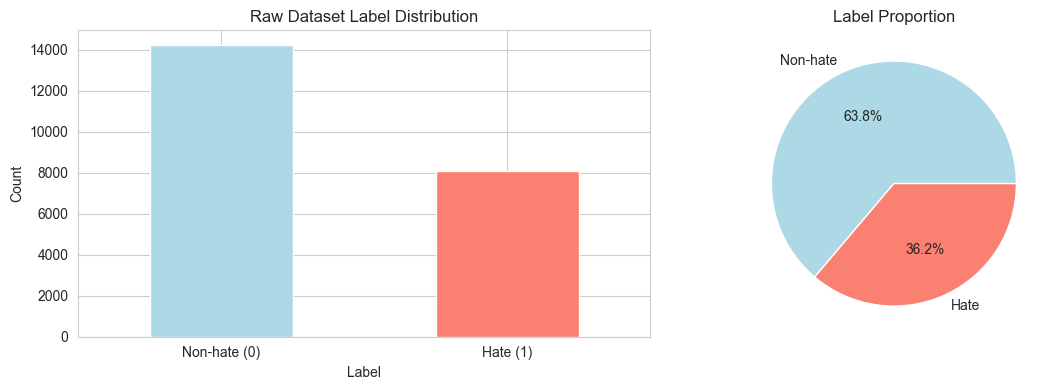

In [20]:
# Load raw dataset
print("=" * 60)
print("LOADING RAW DATASET")
print("=" * 60)

# Define the correct path relative to your current working directory
# Since you're in the eda folder, you need to go up one level to access data
data_path = Path.cwd().parent / 'data' / 'hate.csv'

try:
    df_raw = load_data(str(data_path))
    print(f"\n✅ Successfully loaded dataset from {data_path}")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    # Fallback: try alternative paths
    alternative_paths = [
        '../data/hate.csv',  # Go up one level from eda to access data
        'data/hate.csv',     # If running from project root
        '../data/raw/hate.csv',
        'data/raw/hate.csv',
        'hate.csv'
    ]
    
    df_raw = None
    for alt_path in alternative_paths:
        try:
            df_raw = load_data(alt_path)
            print(f"✅ Loaded from alternative path: {alt_path}")
            break
        except Exception as e2:
            print(f"Failed to load from {alt_path}: {e2}")
            continue
    
    if df_raw is None:
        raise FileNotFoundError("Could not find hate.csv in any expected location")

# Display basic information
print(f"\n📊 Dataset Overview:")
print(f"Shape: {df_raw.shape}")
print(f"Columns: {list(df_raw.columns)}")
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Show first few samples
print(f"\n📋 First 5 samples:")
display(df_raw.head())

# Label distribution
label_dist = df_raw['label'].value_counts().sort_index()
label_props = df_raw['label'].value_counts(normalize=True).sort_index()

print(f"\n🏷️ Label Distribution:")
for label, count in label_dist.items():
    prop = label_props[label]
    label_name = "Non-hate" if label == 0 else "Hate"
    print(f"  {label} ({label_name}): {count:,} samples ({prop:.1%})")

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
label_dist.plot(kind='bar', ax=ax1, color=['lightblue', 'salmon'])
ax1.set_title('Raw Dataset Label Distribution')
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Non-hate (0)', 'Hate (1)'], rotation=0)

# Pie chart
ax2.pie(label_dist.values, labels=['Non-hate', 'Hate'], autopct='%1.1f%%',
        colors=['lightblue', 'salmon'])
ax2.set_title('Label Proportion')

plt.tight_layout()
plt.show()

In [21]:
print("=" * 60)
print("PREPROCESSING DEMONSTRATION")
print("=" * 60)

# Select sample texts for demonstration
sample_indices = [0, 10, 50, 100, 200]  # Mix of different samples
demo_samples = []

for idx in sample_indices:
    if idx < len(df_raw):
        original = df_raw.iloc[idx]['text']
        label = df_raw.iloc[idx]['label']
        demo_samples.append((idx, original, label))

print("🔍 Original Sample Texts:")
print("-" * 80)
for i, (idx, text, label) in enumerate(demo_samples):
    label_name = "Non-hate" if label == 0 else "Hate"
    print(f"Sample {i+1} (Index {idx}, Label: {label_name}):")
    print(f"  Original: {text}")
    print()

# Apply basic cleaning to samples
print("🧹 After Basic Preprocessing:")
print("-" * 80)
for i, (idx, text, label) in enumerate(demo_samples):
    processed = clean_text(text, augment=False, remove_stops=False)
    label_name = "Non-hate" if label == 0 else "Hate"
    print(f"Sample {i+1} (Index {idx}, Label: {label_name}):")
    print(f"  Original:  {text}")
    print(f"  Processed: {processed}")
    print()

# Demonstrate augmentation
print("🔄 Augmentation Example:")
print("-" * 80)
sample_text = demo_samples[0][1]  # Use first sample
print(f"Original: {sample_text}")
print("\nAugmented variants:")
augmented_variants = clean_text(sample_text, augment=True, remove_stops=False)
for i, variant in enumerate(augmented_variants):
    print(f"  Variant {i+1}: {variant}")




PREPROCESSING DEMONSTRATION
🔍 Original Sample Texts:
--------------------------------------------------------------------------------
Sample 1 (Index 0, Label: Non-hate):
  Original: happy new year family beloved sweetheart friends twitter especially great biafrans ipob worldwide

Sample 2 (Index 10, Label: Non-hate):
  Original: see jonathan almajiri boys

Sample 3 (Index 50, Label: Non-hate):
  Original: chuckles knows christians kill making disparaging remarks certain followers another faith tolerant xbb

Sample 4 (Index 100, Label: Hate):
  Original: s3 wa y3 wadwen s3 wo di amafuor mbaa b3 kor bonsam gya mu no de3, 3noa na wo si wo b3 y3. We wie y3 nny3 me f3 kra, nyame betua wo ka paaa kuraseni bermaa

Sample 5 (Index 200, Label: Hate):
  Original: country uk xac aiding abetting islamists sponsors like good friend buhari christians contraption called nigeria xac gave

🧹 After Basic Preprocessing:
--------------------------------------------------------------------------------
Sam

In [22]:
print("=" * 60)
print("FULL DATASET PREPROCESSING")
print("=" * 60)

# Create a copy for processing
df_processed = df_raw.copy()

print("🚀 Processing all texts...")
print("This may take a few minutes for large datasets...")

# Apply preprocessing with progress tracking
processed_texts = []
total_samples = len(df_processed)

# Process in batches for memory efficiency
batch_size = 1000
for i in range(0, total_samples, batch_size):
    batch_end = min(i + batch_size, total_samples)
    batch_texts = df_processed['text'].iloc[i:batch_end]

    # Process batch
    batch_processed = batch_texts.apply(
        lambda x: clean_text(
            x, augment=False, remove_stops=False, handle_code_switch=True)
    )
    processed_texts.extend(batch_processed.tolist())

    # Progress update
    if (i // batch_size) % 5 == 0 or batch_end == total_samples:
        progress = batch_end / total_samples * 100
        print(f"  Progress: {batch_end:,}/{total_samples:,} ({progress:.1f}%)")

# Add processed texts to dataframe
df_processed['processed_text'] = processed_texts

print(f"\n✅ Preprocessing completed!")
print(f"Processed {len(df_processed):,} samples")

# Show comparison of original vs processed
print(f"\n📊 Before/After Comparison:")
comparison_df = pd.DataFrame({
    'Original': df_processed['text'].head(3).tolist(),
    'Processed': df_processed['processed_text'].head(3).tolist()
})

for idx, row in comparison_df.iterrows():
    print(f"\nSample {idx + 1}:")
    print(f"  Original:  {row['Original']}")
    print(f"  Processed: {row['Processed']}")


FULL DATASET PREPROCESSING
🚀 Processing all texts...
This may take a few minutes for large datasets...
  Progress: 1,000/22,307 (4.5%)
  Progress: 6,000/22,307 (26.9%)
  Progress: 11,000/22,307 (49.3%)
  Progress: 16,000/22,307 (71.7%)
  Progress: 21,000/22,307 (94.1%)
  Progress: 22,307/22,307 (100.0%)

✅ Preprocessing completed!
Processed 22,307 samples

📊 Before/After Comparison:

Sample 1:
  Original:  happy new year family beloved sweetheart friends twitter especially great biafrans ipob worldwide
  Processed: happy new year family beloved sweet@@ heart friends twitter espec@@ ially great biafrans ipob worl@@ dwide

Sample 2:
  Original:  covid governors playing politics almajiri ganduje accuses el rufai
  Processed: covid gove@@ rnors playing politics almajiri ganduje accuses el rufai

Sample 3:
  Original:  untitled portrait man pronounced halftone narne jacobson nink cont crayon ballpoint pen graph paper
  Processed: untitled portrait man prono@@ unced halftone narne jacobson n

PIDGIN-SPECIFIC PREPROCESSING ANALYSIS
📝 Spelling Normalization Examples:
--------------------------------------------------
Example 1:
  Original:  date family nigeria xac c nrejected date pick abi pray choke whatever eat date c
  Processed: date family nigeria xac c nrej@@ ected date pick abi pray choke whatever eat date c
  Variations: [('abi', 'abi')]

Example 2:
  Original:  Ah wait oo so they sent this template to kozie and she that job? Girl no wabon oooo herh😂😂😂.
  Processed: ah wait oo so they sent [EN:this] template to kozie [EN:and] she [EN:that] job ? girl no wabon oooo herh [ emoji ] .
  Variations: [('no', 'no')]

Example 3:
  Original:  Kwasia aboa gyimifout te s3 wo, wo maame tw3 s3 Tema harbor, kuraseni odwan m3333!!! Wogyimi aaa wo maame de awo wo wc kurom ha, aboafunu
  Processed: kwasia aboa gyim@@ ifout te s3 wo , wo maame tw3 s3 tema harbor , kuraseni odwan m3333 ! ! ! wogyimi aaa wo maame dey awo wo wc kurom ha , aboafunu
  Variations: [('de', 'dey')]

Example 4:

,Expression,Frequency
2,figa,89
3,hung,83
1,wate,70
4,abeg,51
11,chale,40
10,barb,32
6,wale,31
14,wahala,15
8,sabi,13
5,dey touch,11


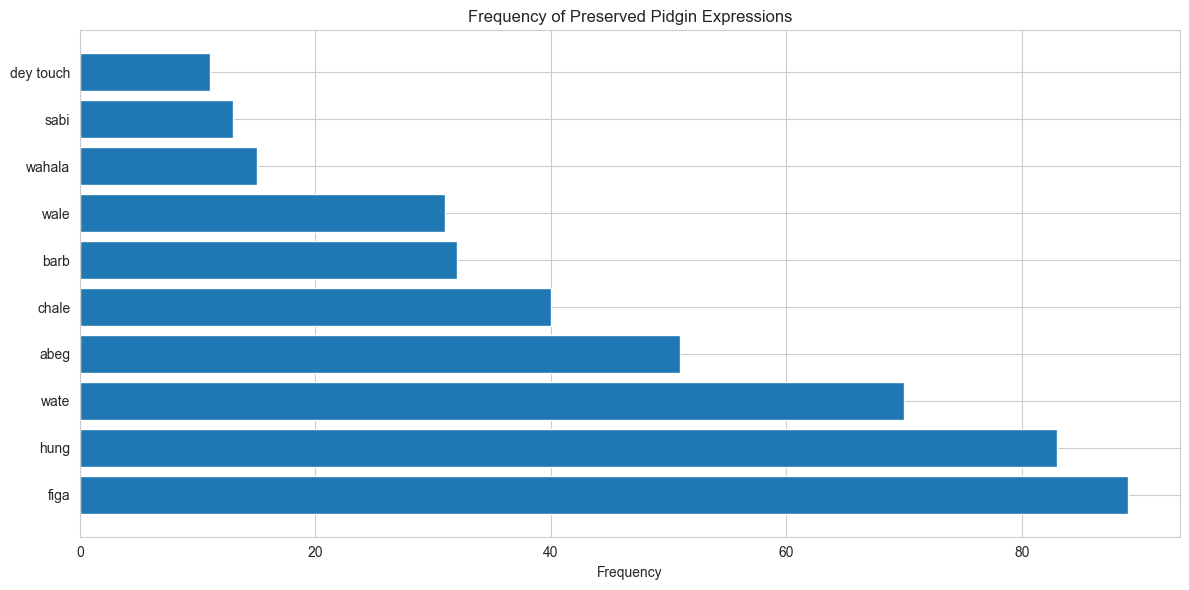

In [23]:
print("=" * 60)
print("PIDGIN-SPECIFIC PREPROCESSING ANALYSIS")
print("=" * 60)

# Analyze spelling normalization effects
print("📝 Spelling Normalization Examples:")
print("-" * 50)

# Find texts with spelling variations
spelling_examples = []
# Check first 100 for examples
for _, row in df_processed.head(100).iterrows():
    original = row['text'].lower()
    processed = row['processed_text'].lower()

    # Check if any spelling dict keys were found and replaced
    found_variations = []
    for variant, standard in SPELLING_DICT.items():
        if variant in original.split() and standard in processed.split():
            found_variations.append((variant, standard))

    if found_variations:
        spelling_examples.append({
            'original': row['text'],
            'processed': row['processed_text'],
            'variations': found_variations
        })

        if len(spelling_examples) >= 5:  # Limit to 5 examples
            break

for i, example in enumerate(spelling_examples):
    print(f"Example {i+1}:")
    print(f"  Original:  {example['original']}")
    print(f"  Processed: {example['processed']}")
    print(f"  Variations: {example['variations']}")
    print()

# Code-switching analysis
print("🌐 Code-Switching Detection:")
print("-" * 50)

# Count texts with code-switching markers
code_switch_count = df_processed['processed_text'].str.contains(r'\[EN:').sum()
total_count = len(df_processed)
code_switch_pct = code_switch_count / total_count * 100

print(
    f"Texts with code-switching: {code_switch_count:,}/{total_count:,} ({code_switch_pct:.1f}%)")

# Show examples of code-switching
cs_examples = df_processed[df_processed['processed_text'].str.contains(
    r'\[EN:')].head(3)
print(f"\nCode-switching examples:")
for idx, row in cs_examples.iterrows():
    print(f"  Original:  {row['text']}")
    print(f"  Processed: {row['processed_text']}")
    print()

# Preserved expressions analysis
print("🛡️ Preserved Pidgin Expressions:")
print("-" * 50)

preserved_counts = {}
for expression in PRESERVE_SET:
    count = df_processed['processed_text'].str.lower(
    ).str.contains(expression).sum()
    if count > 0:
        preserved_counts[expression] = count

preserved_df = pd.DataFrame(list(preserved_counts.items()), columns=[
                            'Expression', 'Frequency'])
preserved_df = preserved_df.sort_values('Frequency', ascending=False)

print("Top preserved expressions:")
display(preserved_df.head(10))

# Visualize preservation
if len(preserved_df) > 0:
    plt.figure(figsize=(12, 6))
    top_10 = preserved_df.head(10)
    plt.barh(top_10['Expression'], top_10['Frequency'])
    plt.title('Frequency of Preserved Pidgin Expressions')
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.show()


TEXT LENGTH ANALYSIS
📏 Length Statistics:


,Original Words,Processed Words,Original Chars,Processed Chars
count,22307.00,22307.00,22307.00,22307.00
mean,14.74,17.00,95.79,105.87
std,8.32,9.77,54.35,60.82
min,1.00,1.00,1.00,1.00
25%,8.00,9.00,50.00,55.00
50%,14.00,16.00,89.00,99.00
75%,21.00,24.00,138.00,152.00
max,62.00,90.00,337.00,381.00


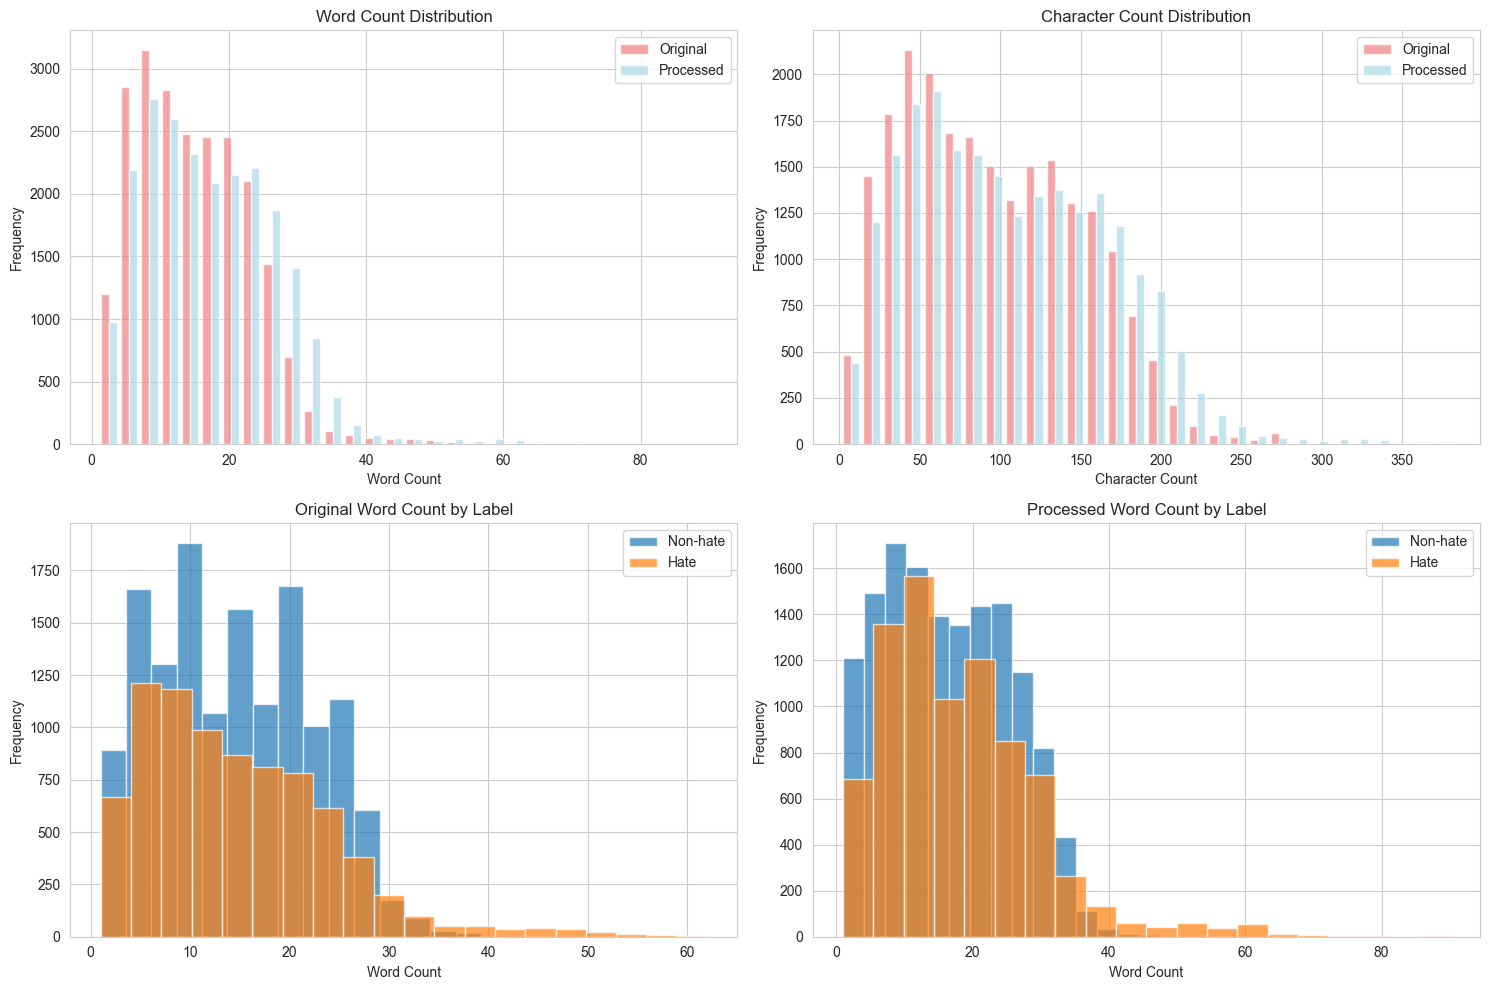

In [24]:
print("=" * 60)
print("TEXT LENGTH ANALYSIS")
print("=" * 60)

# Calculate text statistics
df_processed['orig_word_count'] = df_processed['text'].str.split().str.len()
df_processed['proc_word_count'] = df_processed['processed_text'].str.split().str.len()
df_processed['orig_char_count'] = df_processed['text'].str.len()
df_processed['proc_char_count'] = df_processed['processed_text'].str.len()

# Summary statistics
print("📏 Length Statistics:")
length_stats = pd.DataFrame({
    'Original Words': df_processed['orig_word_count'].describe(),
    'Processed Words': df_processed['proc_word_count'].describe(),
    'Original Chars': df_processed['orig_char_count'].describe(),
    'Processed Chars': df_processed['proc_char_count'].describe()
}).round(2)

display(length_stats)

# Visualize length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Word count comparison
axes[0, 0].hist([df_processed['orig_word_count'], df_processed['proc_word_count']],
                bins=30, alpha=0.7, label=['Original', 'Processed'],
                color=['lightcoral', 'lightblue'])
axes[0, 0].set_title('Word Count Distribution')
axes[0, 0].set_xlabel('Word Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Character count comparison
axes[0, 1].hist([df_processed['orig_char_count'], df_processed['proc_char_count']],
                bins=30, alpha=0.7, label=['Original', 'Processed'],
                color=['lightcoral', 'lightblue'])
axes[0, 1].set_title('Character Count Distribution')
axes[0, 1].set_xlabel('Character Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Length by label - original
for label in [0, 1]:
    label_name = "Non-hate" if label == 0 else "Hate"
    data = df_processed[df_processed['label'] == label]['orig_word_count']
    axes[1, 0].hist(data, alpha=0.7, label=f'{label_name}', bins=20)
axes[1, 0].set_title('Original Word Count by Label')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Length by label - processed
for label in [0, 1]:
    label_name = "Non-hate" if label == 0 else "Hate"
    data = df_processed[df_processed['label'] == label]['proc_word_count']
    axes[1, 1].hist(data, alpha=0.7, label=f'{label_name}', bins=20)
axes[1, 1].set_title('Processed Word Count by Label')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()



DATA BALANCING AND SPLITTING
📊 Original Distribution:
  0 (Non-hate): 14,234 samples (63.8%)
  1 (Hate): 8,073 samples (36.2%)

🔄 Applying SMOTE balancing and train/val/test split...
Original train distribution: {0: 8540, 1: 4843}
Validation distribution: {0: 2847, 1: 1615}
Test distribution: {0: 2847, 1: 1615}
Balanced train distribution: {0: 8540, 1: 8540}
Final sizes - Train: 17080, Val: 4462, Test: 4462

✅ Balancing and splitting completed!

📈 Final Dataset Sizes:
Training set: 17,080 samples
Validation set: 4,462 samples
Test set: 4,462 samples
Total: 26,004 samples

🏷️ Training Set Distribution:
  0 (Non-hate): 8,540 samples (50.0%)
  1 (Hate): 8,540 samples (50.0%)

🏷️ Validation Set Distribution:
  0 (Non-hate): 2,847 samples (63.8%)
  1 (Hate): 1,615 samples (36.2%)

🏷️ Test Set Distribution:
  0 (Non-hate): 2,847 samples (63.8%)
  1 (Hate): 1,615 samples (36.2%)


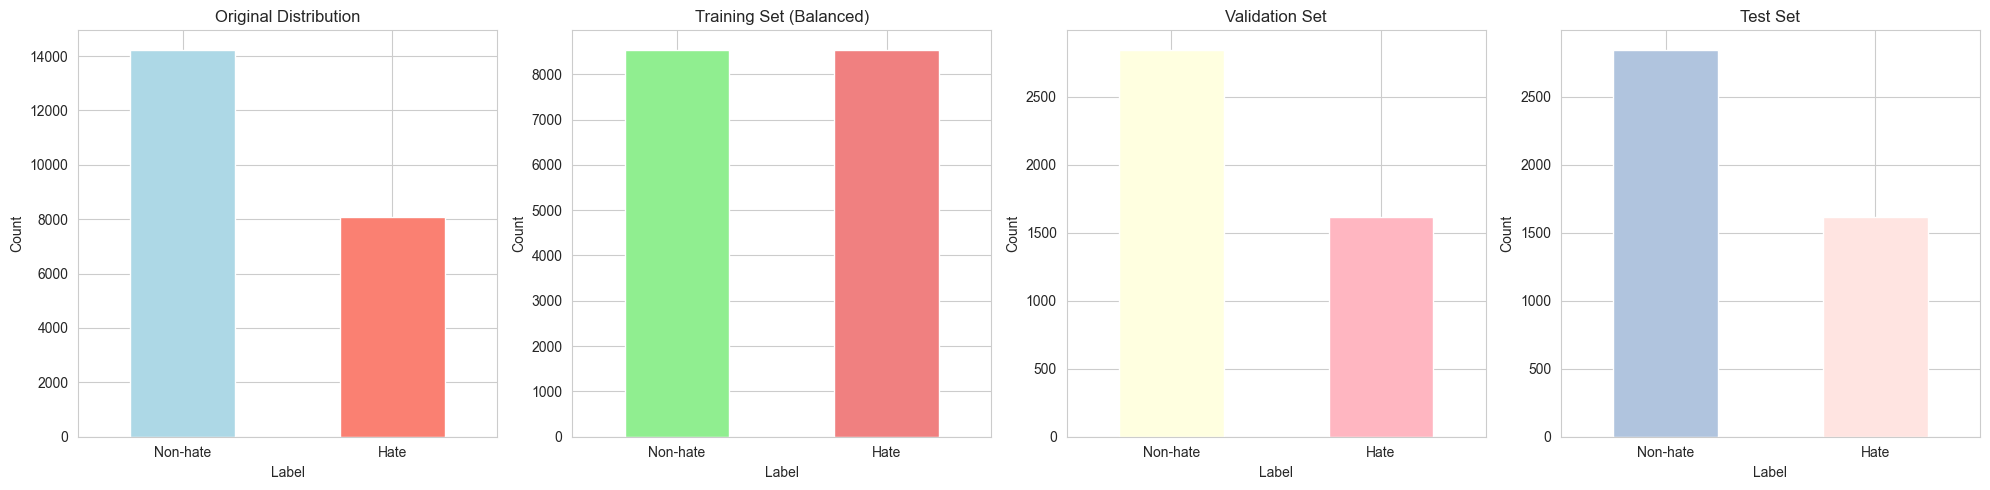

In [26]:
print("=" * 60)
print("DATA BALANCING AND SPLITTING")
print("=" * 60)

# Prepare data for balancing (use processed text)
df_for_balancing = df_processed[['processed_text', 'label']].copy()
df_for_balancing = df_for_balancing.rename(columns={'processed_text': 'text'})

print("📊 Original Distribution:")
orig_dist = df_for_balancing['label'].value_counts().sort_index()
for label, count in orig_dist.items():
    prop = count / len(df_for_balancing) * 100
    label_name = "Non-hate" if label == 0 else "Hate"
    print(f"  {label} ({label_name}): {count:,} samples ({prop:.1f}%)")

# Apply balancing and splitting into train, validation, and test
print(f"\n🔄 Applying SMOTE balancing and train/val/test split...")

try:
    train_df, val_df, test_df = balance_dataset(
        df_for_balancing,
        method='smote',
        val_size=0.2,
        test_size=0.2,
        random_state=42
    )

    print(f"\n✅ Balancing and splitting completed!")

except Exception as e:
    print(f"❌ Error in balancing: {e}")
    print("Falling back to simple oversampling...")

    # Fallback to simple oversampling
    train_df, val_df, test_df = balance_dataset(
        df_for_balancing,
        method='oversample',
        val_size=0.15,
        test_size=0.15,
        random_state=42
    )

# Display results
print(f"\n📈 Final Dataset Sizes:")
print(f"Training set: {len(train_df):,} samples")
print(f"Validation set: {len(val_df):,} samples")
print(f"Test set: {len(test_df):,} samples")
print(f"Total: {len(train_df) + len(val_df) + len(test_df):,} samples")

print(f"\n🏷️ Training Set Distribution:")
train_dist = train_df['label'].value_counts().sort_index()
for label, count in train_dist.items():
    prop = count / len(train_df) * 100
    label_name = "Non-hate" if label == 0 else "Hate"
    print(f"  {label} ({label_name}): {count:,} samples ({prop:.1f}%)")

print(f"\n🏷️ Validation Set Distribution:")
val_dist = val_df['label'].value_counts().sort_index()
for label, count in val_dist.items():
    prop = count / len(val_df) * 100
    label_name = "Non-hate" if label == 0 else "Hate"
    print(f"  {label} ({label_name}): {count:,} samples ({prop:.1f}%)")

print(f"\n🏷️ Test Set Distribution:")
test_dist = test_df['label'].value_counts().sort_index()
for label, count in test_dist.items():
    prop = count / len(test_df) * 100
    label_name = "Non-hate" if label == 0 else "Hate"
    print(f"  {label} ({label_name}): {count:,} samples ({prop:.1f}%)")

# Visualize the balancing effect
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original distribution
orig_dist.plot(kind='bar', ax=axes[0], color=['lightblue', 'salmon'])
axes[0].set_title('Original Distribution')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-hate', 'Hate'], rotation=0)

# Training distribution
train_dist.plot(kind='bar', ax=axes[1], color=['lightgreen', 'lightcoral'])
axes[1].set_title('Training Set (Balanced)')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Non-hate', 'Hate'], rotation=0)

# Validation distribution
val_dist.plot(kind='bar', ax=axes[2], color=['lightyellow', 'lightpink'])
axes[2].set_title('Validation Set')
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Count')
axes[2].set_xticklabels(['Non-hate', 'Hate'], rotation=0)

# Test distribution
test_dist.plot(kind='bar', ax=axes[3], color=['lightsteelblue', 'mistyrose'])
axes[3].set_title('Test Set')
axes[3].set_xlabel('Label')
axes[3].set_ylabel('Count')
axes[3].set_xticklabels(['Non-hate', 'Hate'], rotation=0)

plt.tight_layout()
plt.show()


In [27]:
# Save processed datasets
print("=" * 60)
print("SAVING PROCESSED DATASETS")
print("=" * 60)

# Create output directory
processed_dir = project_root / 'data' / 'processed'
processed_dir.mkdir(parents=True, exist_ok=True)

print(f"💾 Saving datasets to: {processed_dir}")

try:
    save_processed(
        data_dir=str(project_root / 'data'),
        train_df=train_df,
        val_df=val_df,
        test_df=test_df
    )

    print(f"\n✅ Successfully saved processed datasets!")

    # Verify saved files
    train_path = processed_dir / 'train.csv'
    val_path = processed_dir / 'val.csv'
    test_path = processed_dir / 'test.csv'
    stats_path = processed_dir / 'preprocessing_stats.txt'

    print(f"\n📁 Saved files:")
    if train_path.exists():
        size_mb = train_path.stat().st_size / 1024 / 1024
        print(f"  ✅ {train_path} ({size_mb:.2f} MB)")

    if val_path.exists():
        size_mb = val_path.stat().st_size / 1024 / 1024
        print(f"  ✅ {val_path} ({size_mb:.2f} MB)")

    if test_path.exists():
        size_mb = test_path.stat().st_size / 1024 / 1024
        print(f"  ✅ {test_path} ({size_mb:.2f} MB)")

    if stats_path.exists():
        print(f"  ✅ {stats_path}")

        # Display stats
        print(f"\n📊 Preprocessing Statistics:")
        with open(stats_path, 'r') as f:
            print(f.read())

except Exception as e:
    print(f"❌ Error saving datasets: {e}")


SAVING PROCESSED DATASETS
💾 Saving datasets to: c:\Users\infom\Desktop\gh_hate_speech\eda\data\processed
Saved training data: c:\Users\infom\Desktop\gh_hate_speech\eda\data\processed\train.csv (17080 samples)
Saved validation data: c:\Users\infom\Desktop\gh_hate_speech\eda\data\processed\val.csv (4462 samples)
Saved test data: c:\Users\infom\Desktop\gh_hate_speech\eda\data\processed\test.csv (4462 samples)
Saved preprocessing statistics: c:\Users\infom\Desktop\gh_hate_speech\eda\data\processed\preprocessing_stats.txt

✅ Successfully saved processed datasets!

📁 Saved files:
  ✅ c:\Users\infom\Desktop\gh_hate_speech\eda\data\processed\train.csv (1.84 MB)
  ✅ c:\Users\infom\Desktop\gh_hate_speech\eda\data\processed\val.csv (0.47 MB)
  ✅ c:\Users\infom\Desktop\gh_hate_speech\eda\data\processed\test.csv (0.47 MB)
  ✅ c:\Users\infom\Desktop\gh_hate_speech\eda\data\processed\preprocessing_stats.txt

📊 Preprocessing Statistics:
train_samples: 17080
val_samples: 4462
test_samples: 4462
train_h

VALIDATION AND QUALITY CHECKS
✅ Successfully loaded saved datasets for verification

🔍 Basic Validation:
Training samples: 17,080
Validation samples: 4,462
Test samples: 4,462
Training columns: ['text', 'label']
Validation columns: ['text', 'label']
Test columns: ['text', 'label']

🚫 Missing Values Check:
Training set missing values:
text     0
label    0
dtype: int64
Validation set missing values:
text     0
label    0
dtype: int64
Test set missing values:
text     0
label    0
dtype: int64

📏 Text Length Validation:
Training text lengths - Min: 2, Max: 488, Mean: 108.2
Validation text lengths - Min: 2, Max: 381, Mean: 106.1
Test text lengths - Min: 1, Max: 369, Mean: 107.2
Empty texts - Training: 0, Validation: 0, Test: 0

📚 Vocabulary Analysis:
Training vocabulary:
  Total tokens: 321,263
  Unique tokens: 27,470
  Type-Token Ratio: 0.0855
Validation vocabulary:
  Total tokens: 75,888
  Unique tokens: 13,827
  Type-Token Ratio: 0.1822
Test vocabulary:
  Total tokens: 76,711
  Unique 

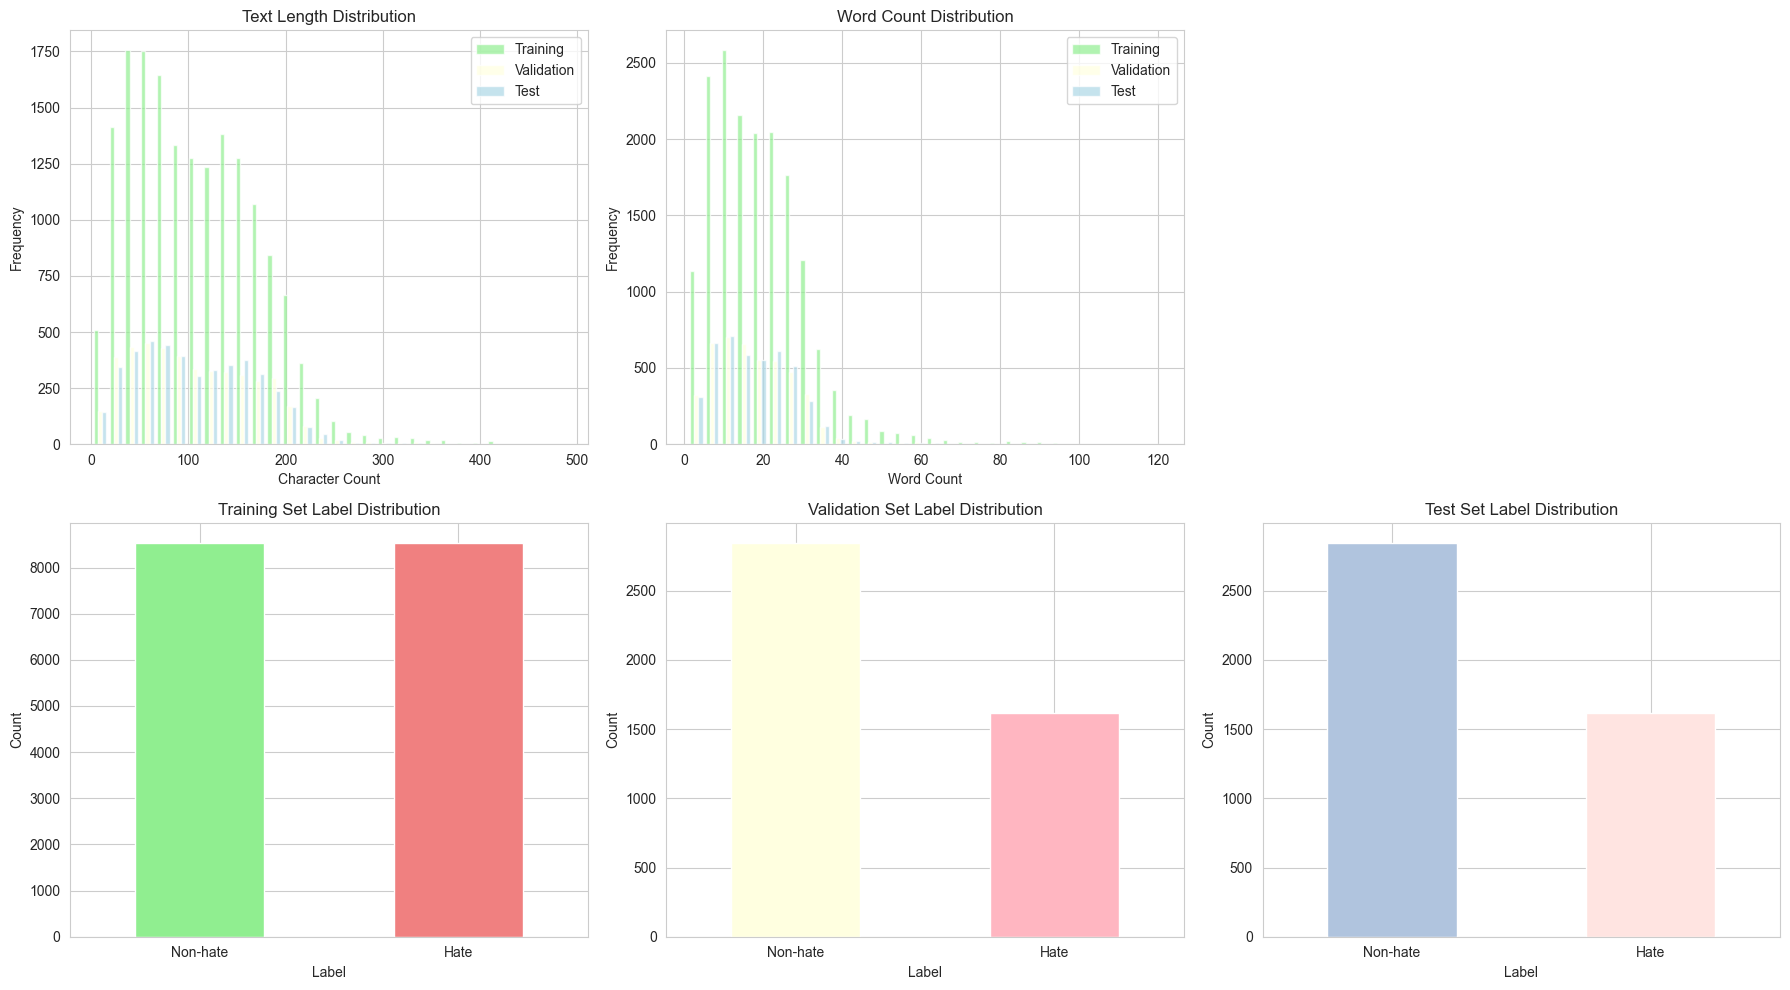


✅ Validation completed! Datasets are ready for feature engineering and modeling.


In [28]:
print("=" * 60)
print("VALIDATION AND QUALITY CHECKS")
print("=" * 60)

# Load saved datasets for verification
try:
    train_check = pd.read_csv(processed_dir / 'train.csv')
    val_check = pd.read_csv(processed_dir / 'val.csv')
    test_check = pd.read_csv(processed_dir / 'test.csv')
    print(f"✅ Successfully loaded saved datasets for verification")
except Exception as e:
    print(f"❌ Error loading saved datasets: {e}")
    train_check, val_check, test_check = train_df, val_df, test_df

# Basic validation
print(f"\n🔍 Basic Validation:")
print(f"Training samples: {len(train_check):,}")
print(f"Validation samples: {len(val_check):,}")
print(f"Test samples: {len(test_check):,}")
print(f"Training columns: {list(train_check.columns)}")
print(f"Validation columns: {list(val_check.columns)}")
print(f"Test columns: {list(test_check.columns)}")

# Check for missing values
print(f"\n🚫 Missing Values Check:")
print(f"Training set missing values:")
print(train_check.isnull().sum())
print(f"Validation set missing values:")
print(val_check.isnull().sum())
print(f"Test set missing values:")
print(test_check.isnull().sum())

# Check text lengths
print(f"\n📏 Text Length Validation:")
train_lengths = train_check['text'].str.len()
val_lengths = val_check['text'].str.len()
test_lengths = test_check['text'].str.len()

print(
    f"Training text lengths - Min: {train_lengths.min()}, Max: {train_lengths.max()}, Mean: {train_lengths.mean():.1f}")
print(
    f"Validation text lengths - Min: {val_lengths.min()}, Max: {val_lengths.max()}, Mean: {val_lengths.mean():.1f}")
print(
    f"Test text lengths - Min: {test_lengths.min()}, Max: {test_lengths.max()}, Mean: {test_lengths.mean():.1f}")

# Check for empty texts
empty_train = (train_check['text'].str.strip() == '').sum()
empty_val = (val_check['text'].str.strip() == '').sum()
empty_test = (test_check['text'].str.strip() == '').sum()
print(
    f"Empty texts - Training: {empty_train}, Validation: {empty_val}, Test: {empty_test}")

# Vocabulary analysis
print(f"\n📚 Vocabulary Analysis:")


def get_vocab_stats(texts):
    all_words = []
    for text in texts:
        if pd.notna(text):
            words = str(text).lower().split()
            all_words.extend(words)

    unique_words = set(all_words)
    return len(all_words), len(unique_words), len(unique_words) / len(all_words) if all_words else 0


train_total, train_unique, train_ttr = get_vocab_stats(train_check['text'])
val_total, val_unique, val_ttr = get_vocab_stats(val_check['text'])
test_total, test_unique, test_ttr = get_vocab_stats(test_check['text'])

print(f"Training vocabulary:")
print(f"  Total tokens: {train_total:,}")
print(f"  Unique tokens: {train_unique:,}")
print(f"  Type-Token Ratio: {train_ttr:.4f}")

print(f"Validation vocabulary:")
print(f"  Total tokens: {val_total:,}")
print(f"  Unique tokens: {val_unique:,}")
print(f"  Type-Token Ratio: {val_ttr:.4f}")

print(f"Test vocabulary:")
print(f"  Total tokens: {test_total:,}")
print(f"  Unique tokens: {test_unique:,}")
print(f"  Type-Token Ratio: {test_ttr:.4f}")

# Sample texts from each set
print(f"\n📖 Sample Processed Texts:")
print(f"\nTraining samples:")
for i in range(min(3, len(train_check))):
    label = train_check.iloc[i]['label']
    text = train_check.iloc[i]['text']
    label_name = "Non-hate" if label == 0 else "Hate"
    print(f"  {i+1}. [{label_name}] {text}")

print(f"\nValidation samples:")
for i in range(min(3, len(val_check))):
    label = val_check.iloc[i]['label']
    text = val_check.iloc[i]['text']
    label_name = "Non-hate" if label == 0 else "Hate"
    print(f"  {i+1}. [{label_name}] {text}")

print(f"\nTest samples:")
for i in range(min(3, len(test_check))):
    label = test_check.iloc[i]['label']
    text = test_check.iloc[i]['text']
    label_name = "Non-hate" if label == 0 else "Hate"
    print(f"  {i+1}. [{label_name}] {text}")

# Compare distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Text length distributions
axes[0, 0].hist([train_lengths, val_lengths, test_lengths], bins=30, alpha=0.7,
                label=['Training', 'Validation', 'Test'],
                color=['lightgreen', 'lightyellow', 'lightblue'])
axes[0, 0].set_title('Text Length Distribution')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Word count distributions
train_words = train_check['text'].str.split().str.len()
val_words = val_check['text'].str.split().str.len()
test_words = test_check['text'].str.split().str.len()

axes[0, 1].hist([train_words, val_words, test_words], bins=30, alpha=0.7,
                label=['Training', 'Validation', 'Test'],
                color=['lightgreen', 'lightyellow', 'lightblue'])
axes[0, 1].set_title('Word Count Distribution')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Label distributions - Training
train_check['label'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 0],
                                                      color=['lightgreen', 'lightcoral'])
axes[1, 0].set_title('Training Set Label Distribution')
axes[1, 0].set_xlabel('Label')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticklabels(['Non-hate', 'Hate'], rotation=0)

# Label distributions - Validation
val_check['label'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 1],
                                                    color=['lightyellow', 'lightpink'])
axes[1, 1].set_title('Validation Set Label Distribution')
axes[1, 1].set_xlabel('Label')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xticklabels(['Non-hate', 'Hate'], rotation=0)

# Label distributions - Test
test_check['label'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 2],
                                                     color=['lightsteelblue', 'mistyrose'])
axes[1, 2].set_title('Test Set Label Distribution')
axes[1, 2].set_xlabel('Label')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_xticklabels(['Non-hate', 'Hate'], rotation=0)

# Remove empty subplot
axes[0, 2].remove()

plt.tight_layout()
plt.show()

print(f"\n✅ Validation completed! Datasets are ready for feature engineering and modeling.")


In [29]:
# Final summary statistics
print("=" * 60)
print("FINAL PREPROCESSING SUMMARY")
print("=" * 60)

summary_stats = {
    'Original Dataset Size': len(df_raw),
    'Processed Dataset Size': len(df_processed),
    'Training Set Size': len(train_check),
    'Validation Set Size': len(val_check),
    'Test Set Size': len(test_check),
    'Training Hate Ratio': train_check['label'].mean(),
    'Validation Hate Ratio': val_check['label'].mean(),
    'Test Hate Ratio': test_check['label'].mean(),
    'Avg Original Text Length': df_raw['text'].str.len().mean(),
    'Avg Processed Text Length': train_check['text'].str.len().mean(),
    'Vocabulary Reduction': f"{(1 - test_unique/train_unique)*100:.1f}%" if train_unique > 0 else "N/A"
}

print("📊 Key Metrics:")
for metric, value in summary_stats.items():
    if isinstance(value, float):
        print(f"  {metric}: {value:.3f}")
    else:
        print(f"  {metric}: {value:,}" if isinstance(
            value, int) else f"  {metric}: {value}")

print(f"\n🎯 Ready for next stage: Feature Engineering!")
print(f"📁 Processed data location: {processed_dir}")
print(f"📝 Next notebook: 03_feature_engineering.ipynb")

print(f"\n📋 Dataset Split Summary:")
print(f"  Training:   {len(train_check):,} samples ({len(train_check)/(len(train_check)+len(val_check)+len(test_check))*100:.1f}%)")
print(f"  Validation: {len(val_check):,} samples ({len(val_check)/(len(train_check)+len(val_check)+len(test_check))*100:.1f}%)")
print(f"  Test:       {len(test_check):,} samples ({len(test_check)/(len(train_check)+len(val_check)+len(test_check))*100:.1f}%)")


FINAL PREPROCESSING SUMMARY
📊 Key Metrics:
  Original Dataset Size: 22,307
  Processed Dataset Size: 22,307
  Training Set Size: 17,080
  Validation Set Size: 4,462
  Test Set Size: 4,462
  Training Hate Ratio: 0.500
  Validation Hate Ratio: 0.362
  Test Hate Ratio: 0.362
  Avg Original Text Length: 95.791
  Avg Processed Text Length: 108.172
  Vocabulary Reduction: 49.7%

🎯 Ready for next stage: Feature Engineering!
📁 Processed data location: c:\Users\infom\Desktop\gh_hate_speech\eda\data\processed
📝 Next notebook: 03_feature_engineering.ipynb

📋 Dataset Split Summary:
  Training:   17,080 samples (65.7%)
  Validation: 4,462 samples (17.2%)
  Test:       4,462 samples (17.2%)
